# ***The Multi-Armed Bandit***

### Objectives: answer the following

 * What are ***exploitation***, ***exploration***, and ***regret*** in this context?
 * How is this framework related to traditional A/B testing?
 * What’s your favorite strategy?

In [1]:
import numpy as np
import random
probabilities = np.arange(.58,.2,-.16)
random.shuffle(probabilities)
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## An example: treatments for tongue psoriasis

Suppose you're a doctor who has developed a new treatment for tongue psoriasis. You aren't sure it will actually help, so you want to compare it to a control group.

How would you do that?

What if you were a Bayesian?

The problem is that these are real people, suffering a real problem, and you want to help as many as possible.

In [2]:
probability = {}
probability['control'] = probabilities[0]
probability['drug'] = probabilities[1]
results = dict(control=[], drug=[], total=[])

In [3]:
def run_test(treatment):
    result = stats.bernoulli(probability[treatment]).rvs()
    results[treatment].append(result)
    results['total'].append(result)
    if result:
        print("The patient got better!")
    else:
        print("The patient is still sick :(")
    print("        got better   didn't")
    for treatment in ['control', 'drug', 'total']:
        print("{:10} {:5}  {:5}".format(treatment, results[treatment].count(1), results[treatment].count(0)))

Let's test some patients, giving some the drug and some not.

In [4]:
run_test('control')

The patient got better!
        got better   didn't
control        1      0
drug           0      0
total          1      0


In [5]:
run_test('drug')

The patient is still sick :(
        got better   didn't
control        1      0
drug           0      1
total          1      1


In [6]:
results

{'control': [1], 'drug': [0], 'total': [1, 0]}

In [7]:
print('Experimental success rates:')
for treatment in ['control', 'drug']:
    print("  {:10} {:5.2f}".format(treatment, np.mean(results[treatment])))

Experimental success rates:
  control     1.00
  drug        0.00


In [8]:
print('Actual probabilities of getting better:')
for treatment in ['control', 'drug']:
    print("  {:10} {:5.2f}".format(treatment, probability[treatment]))

Actual probabilities of getting better:
  control     0.58
  drug        0.42


With traditional A/B testing there are two phases. First we collect data to determine the best choice, known as **exploration**. Once we're done testing, we make a decision between our options and stick with it; this is **exploitation**. Sometimes it's necessary to keep the testing phase strictly before the deployment phase, but what if there is no such restriction? Then we can combine the two phases, starting out exploring possible results and gradually concentrating on the best choice.

## The Multi-Armed Bandit

The multi-armed bandit is a mathematical problem. Suppose we have two or more slot machines, and each slot machine (a.k.a. one-armed bandit) has a different (unknown!) chance of winning. What strategy should we follow to maximize our payoff after a finite number of plays?
- bandits: $\{B_i\}$
- bandit payout probabilities: $\{p_i\}$

In this case we're assuming they all have the same payoff amount ("binary bandits"), but different payout probabilities (there are many extensions of this problem, but this is a sufficient starting point).

In reality these "bandits" might be drugs, or web-site designs, or ad campaigns, or job-search strategies, or dating profiles, or restaurants, or anything where we want to exploit the "winner" of our hypothesis testing.

- exploration: collecting more data for each bandit to get a better estimate of the true payout probabilities
- eploitation: using whichever bandit has performed the best so far

We are going to explore several different strategies for balancing exploration and exploitation.

Each strategy will also have to track the performance of each bandit:
- $n_i$: number of visits (or rounds, or pulls) to bandit $B_i$
- $w_i$: number of successes at bandit $B_i$
- $\hat{p}_i = w_i / n_i $: observed success rate of bandit $B_i$
  - if $n_i = 0$, this is undefined



## Common strategies

There are a number of common strategies that you'll implement in the assignment. Some are better than others, although a "best" strategy would require knowledge of the distribution of the payoffs.

To quantify a strategy's performance, we run simulations where we know the true payout probabilities and calculate **regret**: the expected difference in winnings between our strategy and the optimal one.
- let $p^*$ be the max of $\{p_1, p_2, p_3, \ldots, p_k\}$ 
- let $p(t)$ be the true success probability of the bandit chosed at round $t$
- then our regret after $T$ rounds is
$$ r = Tp^* - \sum_{t=1}^T p(t) $$
- and our expected average regret per round is 
$$ E[\bar{r}] = \lim_{T \rightarrow \infty} r / T = p^* - \frac{1}{T}\sum_{t=1}^Tp(t)$$

We want a strategy that minimizes regret
- A ***zero-regret strategy*** is defined as one with $E[\bar{r}] = 0$
- A zero-regret strategy does not guarantee that you will never choose a suboptimal outcome, instead it guarantees that as you continue to play you will tend to choose the optimal outcome more and more often.
- Note again that actually calculating regret requires knowing the true bandit probabilities


### Greedy Algorithm

The simplest model is a "greedy" algorithm, where we always choose the bandit that's been the most successful so far. Since we want to be able to explore at least a little, we might assume that each bandit has already had a single success.

What are the limitations of this?


### Epsilon-Greedy Algorithm

With epsilon-greedy we choose the best algorithm most of the time, but sometimes (with probability $\epsilon$) we choose one randomly.

Again, there isn't a "best" value, but $\epsilon = 0.1$ is typical.

- ***explore*** with some fixed probability $\epsilon$
  - generate a random number between 0 and 1. If it is less than $\epsilon$, choose a random bandit
- ***exploit*** at all other times: choose the bandit with the highest $\hat{p}_i$ 


Is this a zero-regret strategy?

### Softmax


Here we create a probability of choosing a bandit according to the following formula:
$$ P(B_i) = \frac{e^{\hat{p}_i/\tau}}{\sum_{j=1}^k e^{\hat{p}_j/\tau}} $$

* $\hat{p}_i$ is the observed success rate so far.
* $\tau$ is the "temperature" parameter

We then ***sample*** from this distribution to choose a bandit.

For example, if there are three bandits, A, B, and C, then
$$ P(A) = \frac{e^{\hat{p}_A/\tau}}{e^{\hat{p}_A/\tau}+e^{\hat{p}_B/\tau}+e^{\hat{p}_C/\tau}} $$




How does this behave in the extremes?


* As $\tau \to \infty$, the algorithm will choose bandits equally.
* As $\tau \to 0$, it will choose the most successful so far.

This is not zero regret, but we can make it zero-regret if we decrease $\tau$ over time. See [this paper](https://arxiv.org/pdf/1705.10257.pdf)

##### coding tip
The quickest way to make your own discrete random variable: `np.random.choice` takes an array and a parameter `p` defining the probability of choosing each element in the array

In [9]:
np.random.choice(['a', 'b', 'c'], size=30, p=[0.8, 0.1, 0.1])

array(['a', 'a', 'a', 'c', 'b', 'a', 'b', 'a', 'c', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a'],
      dtype='<U1')

##### numpy exercise
say I have four bandits with the following data

In [10]:
trials = np.array([23,44,12,15])
wins = np.array([5,5,4,6])

make a numpy array of the softmax probabilities

### UCB1 Algorithm ("upper confidence bound")

The UCB1 algorithm scores each bandit based on the following formula:

$$\text{score}_i = \hat{p}_i + \sqrt{\frac{2 \ln{T}}{n_i}} $$

where

 * $\hat{p}_i$ is the observed success rate of $B_i$ so far
 * $n_i$ is the number of times bandit $B_i$ has played
 * T is the total number of trials so far

The bandit with the highest score is chosen.

This strategy is zero regret. Proof [here](https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/).

### Bayesian Bandits (a.k.a. "Thompson sampling")

Use Bayesian updating to make a beta distribution for each bandit, where
$$ \alpha_i = 1 + w_i ;\\ \beta_i = 1 + n_i - w_i $$

Then sample from each bandit's posterior distribution. Choose the bandit whose sample was highest. 



##### exercise: sampling from a bunch of distributions

In [11]:
trials = np.array([23,44,12,15])
wins = np.array([5,5,4,6])

In [12]:
p_hat = wins / trials
p_hat

array([ 0.2173913 ,  0.11363636,  0.33333333,  0.4       ])

In [13]:
all_betas = stats.beta(1 + wins, 1 + trials - wins)
all_betas

In [14]:
samples = all_betas.rvs()
samples

array([ 0.35479326,  0.12914209,  0.3121087 ,  0.42732955])

In [15]:
samples.max()

0.42732954946794083

In [16]:
samples.argmax()

3

#### simulation

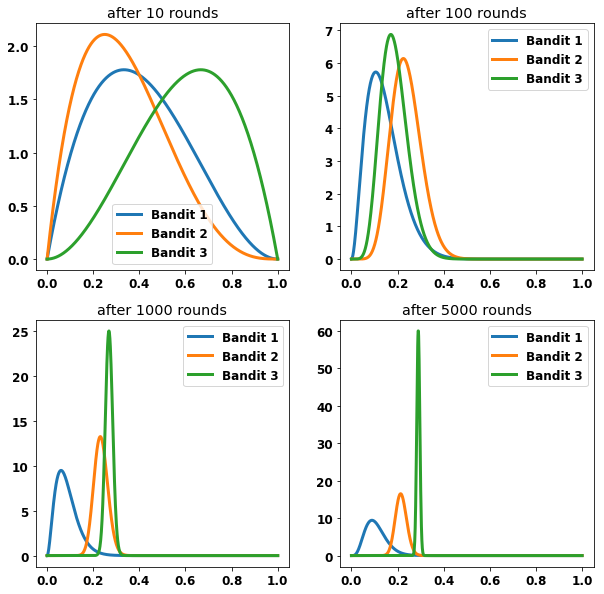

In [17]:
fig, axs = plt.subplots(2,2, figsize= (10,10))
x = np.linspace(0,1,1000)
plot_counter = 0

true_p = [0.1, 0.2, 0.3]

def pull(i):
    return random.random() < true_p[i]

wins = np.zeros(3)
trials = np.zeros(3)

for n in range(5000):
    all_betas = stats.beta(1 + wins, 1 + trials - wins)
    samples = all_betas.rvs()
    choice = samples.argmax()
    win = pull(choice)
    wins[choice] += win
    trials[choice] += 1
    if n in [9, 99, 999, 4999]:
        ax = axs.flatten()[plot_counter]
        for i in range(len(wins)):
            beta = stats.beta(1 + wins[i], 1 + trials[i] - wins[i])
            ax.plot(x, beta.pdf(x), 
                    label='Bandit {}'.format(i+1),
                    linewidth=3)
            ax.set_title('after {} rounds'.format(n + 1))
            ax.legend()
        plot_counter+=1
    

Though Thompson sampling has been around since the 1930s, it has only recently (2012) been proved to be a zero-regret strategy. See [this](http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf) paper.

More good papers [here](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) and [here](https://arxiv.org/pdf/1710.02869.pdf)

### more fun numpy tricks

you can use a list of indices to index a numpy array

In [18]:
foo = np.array([2,5,1,7,9,6,3,2,5,8])
foo

array([2, 5, 1, 7, 9, 6, 3, 2, 5, 8])

In [19]:
foo[[1,1,1,4, 4, 4, 4]]

array([5, 5, 5, 9, 9, 9, 9])

Boolean indexing / masking

In [20]:
bar = np.arange(10)
bar

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
foo

array([2, 5, 1, 7, 9, 6, 3, 2, 5, 8])

In [22]:
foo > bar

array([ True,  True, False,  True,  True,  True, False, False, False, False], dtype=bool)

In [23]:
np.mean(foo > bar)

0.5

In [24]:
np.sum(foo>bar)

5

In [25]:
mask = foo > bar
mask

array([ True,  True, False,  True,  True,  True, False, False, False, False], dtype=bool)

In [26]:
foo[mask]

array([2, 5, 7, 9, 6])

In [27]:
bar[mask]

array([0, 1, 3, 4, 5])

In [28]:
bar[~mask]

array([2, 6, 7, 8, 9])